## Downloading The Dataset

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"1e8e85d548f349b67f2e015da44880bd"}'}

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tgdivy/poetry-foundation-poems

 56% 5.00M/8.88M [00:00<00:00, 28.0MB/s]
100% 8.88M/8.88M [00:00<00:00, 35.3MB/s]


In [4]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/poetry-foundation-poems.zip'

with ZipFile(file_name, 'r') as zipextractor:
  zipextractor.extractall()
  print('Done')

Done


## Importing The Libraries

In [5]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout, LSTM, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

## Reading The Dataset

In [7]:
data = pd.read_csv('/content/PoetryFoundationData.csv')
data = data[:520]
data.sample(4)

,Unnamed: 0,Title,Poem,Poet,Tags
70,70,\r\r\n from Poems of the Th...,\r\r\nOur lives no longer feel ground under th...,Osip Mandelstam,History & Politics
199,14,\r\r\n Lifting My Daughter\...,\r\r\nAs I leave for work she holds out her ar...,Joseph Hutchison,NaN
206,21,\r\r\n Coquí\r\r\n ...,\r\r\nOne tiny tree frog\r\r\nwith big eyes\r\...,Carmen Bernier-Grand,"Nature,Animals"
354,169,\r\r\n Thaw\r\r\n ...,\r\r\nYou said I will pull you out of my body ...,TC Tolbert,"Living,The Body,Love,Realistic & Complicated,R..."


In [8]:
poem_data = pd.DataFrame({'Poem':data['Poem'].values})
poem_data.sample(4)

,Poem
213,"\r\r\nWe used to play, long before we bought r..."
122,\r\r\nWhitman thought he could live with anima...
68,\r\r\nLet me be in your service\r\r\nlike the ...
513,"\r\r\nI come from Inuit oil money,\r\r\nFrom i..."


## Removing Lines

In [9]:
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: x.splitlines()) 
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: " ".join(x)) 

In [10]:
poem_data['Poem'][0]

"  Dog bone, stapler,  cribbage board, garlic press       because this window is loose—lacks  suction, lacks grip.  Bungee cord, bootstrap,  dog leash, leather belt       because this window had sash cords.  They frayed. They broke.  Feather duster, thatch of straw, empty  bottle of Elmer's glue       because this window is loud—its hinges clack  open, clack shut.  Stuffed bear, baby blanket,  single crib newel       because this window is split. It's dividing  in two.  Velvet moss, sagebrush,  willow branch, robin's wing       because this window, it's pane-less. It's only  a frame of air. "

## Cleaning The Text

In [11]:
!pip -q install contractions
import contractions
import unicodedata

     |████████████████████████████████| 327kB 10.3MB/s 
     |████████████████████████████████| 286kB 23.6MB/s 


In [12]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [13]:
def get_clean(X):
    X = str(X).lower().replace('\\', ' ').replace('_', ' ').replace(':', '')
    X = contractions.fix(X)
    X = X.replace('#', "")
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'[^\w\d\s]+','', X)
    X = ' '.join(X.split())
    X = BeautifulSoup(X, 'lxml').get_text().strip()
    X = remove_accented(X)
    return X

In [14]:
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: get_clean(x)) 
poem_data['Poem'][0]

'dog bone stapler cribbage board garlic press because this window is looselacks suction lacks grip bungee cord bootstrap dog leash leather belt because this window had sash cords they frayed they broke feather duster thatch of straw empty bottle of elmers glue because this window is loudits hinges clack open clack shut stuffed bear baby blanket single crib newel because this window is split it is dividing in two velvet moss sagebrush willow branch robins wing because this window it is paneless it is only a frame of air'

## Word Cloud Representation


In [15]:
plt.rcParams['figure.figsize'] = [4,4]
plt.rcParams['figure.dpi'] = 120
sns.set(style='darkgrid')

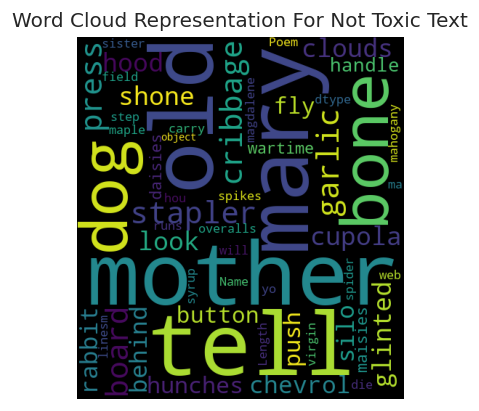

In [16]:
poems = str(poem_data['Poem'])
word_cloud = WordCloud(width=450, height=500, max_font_size=120).generate(poems)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Not Toxic Text')
plt.axis('off')
plt.show()

## Converting Text Into Numerical Form

In [17]:
token = Tokenizer()
token.fit_on_texts(poem_data['Poem'])

In [18]:
encoded_text = token.texts_to_sequences(poem_data['Poem'])

In [19]:
vocab_size = len(token.word_counts) + 1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 15986


## Building The Data

In [20]:
datalist = []
for d in encoded_text:
  if len(d)>1:
    for i in range(2, len(d)):
      datalist.append(d[:i])

In [21]:
max_length = 5
sequences = pad_sequences(datalist, maxlen=max_length, padding='pre')

In [24]:
seq_length = X.shape[1]
print(f'Sequence Length: {seq_length}')

Sequence Length: 4


## Dividing The Data

In [22]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [23]:
y = to_categorical(y, num_classes=vocab_size)

## Building The Model

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation='softmax'))

## Understanding The Model

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 50)             799300    
_________________________________________________________________
lstm (LSTM)                  (None, 4, 100)            60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 15986)             1614586   
Total params: 2,565,186
Trainable params: 2,564,986
Non-trainable params: 200
____________________________________________

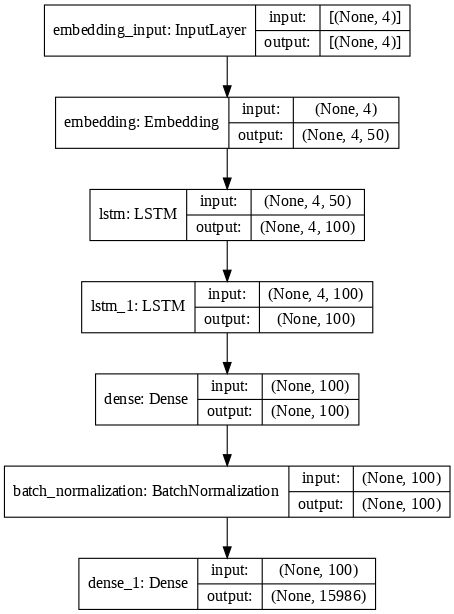

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

## Compiling The Model

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training The Model

In [29]:
r = model.fit(X, y, batch_size=100, epochs=170)

Epoch 1/170
1195/1195 [==============================] - 57s 20ms/step - loss: 7.7653 - accuracy: 0.0648
Epoch 2/170
1195/1195 [==============================] - 24s 20ms/step - loss: 6.4030 - accuracy: 0.1048
Epoch 3/170
1195/1195 [==============================] - 23s 19ms/step - loss: 5.9891 - accuracy: 0.1236
Epoch 4/170
1195/1195 [==============================] - 24s 20ms/step - loss: 5.5923 - accuracy: 0.1428
Epoch 5/170
1195/1195 [==============================] - 23s 19ms/step - loss: 5.1656 - accuracy: 0.1679
Epoch 6/170
1195/1195 [==============================] - 23s 19ms/step - loss: 4.7120 - accuracy: 0.1994
Epoch 7/170
1195/1195 [==============================] - 22s 19ms/step - loss: 4.2891 - accuracy: 0.2457
Epoch 8/170
1195/1195 [==============================] - 22s 19ms/step - loss: 3.8897 - accuracy: 0.2969
Epoch 9/170
1195/1195 [==============================] - 23s 19ms/step - loss: 3.5603 - accuracy: 0.3450
Epoch 10/170
1195/1195 [==============================]

## Accuracy and Loss

In [31]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The traning loss of model is {r.history["loss"][-1]:.3f}')

The traning accuracy of model is 94 %
The traning loss of model is 0.204


In [44]:
plt.rcParams['figure.figsize'] = [22,6]
plt.rcParams['figure.dpi'] = 75

## Visualizing The Accuracy

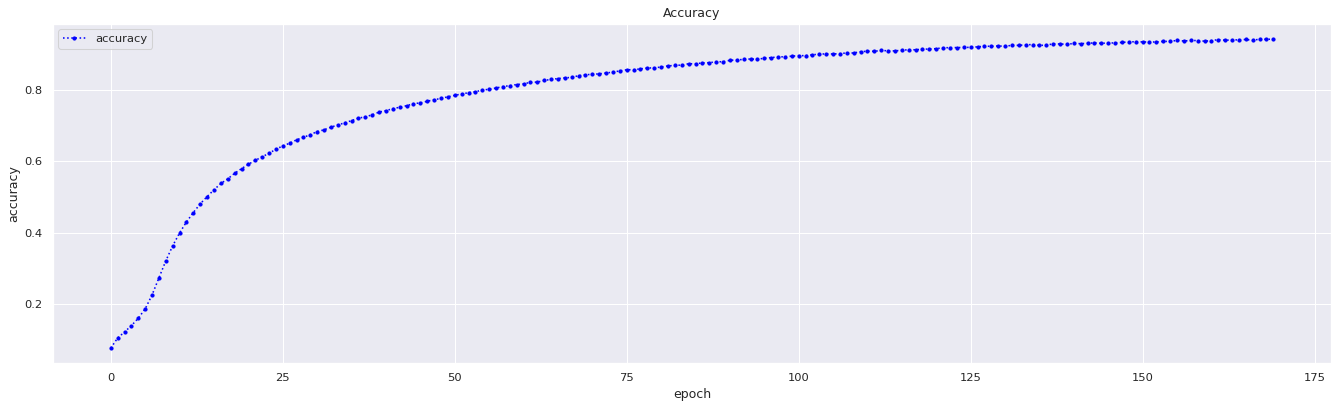

In [45]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Visualizing The Loss

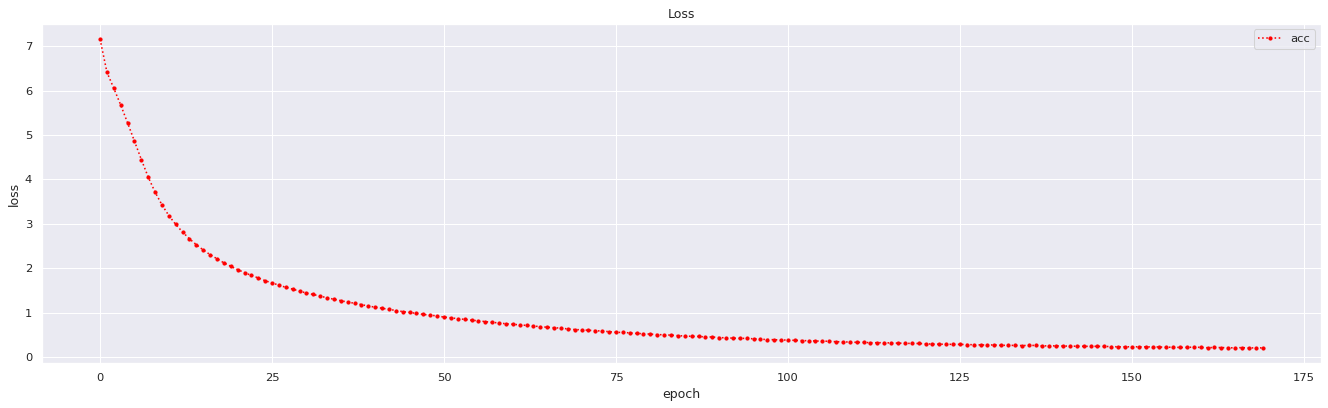

In [46]:
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='acc', linewidth=1.5, color="red")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Generating The Poems




In [47]:
poetry_length = 10

def generate_poetry(seed_text, n_lines):

  for i in range(n_lines):
    text = []
    for _ in range(poetry_length):
      encoded = token.texts_to_sequences([seed_text])
      encoded = pad_sequences(encoded, maxlen=seq_length, padding='pre')

      y_pred = np.argmax(model.predict(encoded), axis=-1)

      predicted_word = ""
      for word, index in token.word_index.items():
        if index == y_pred:
          predicted_word = word
          break

      seed_text = seed_text + ' ' + predicted_word
      text.append(predicted_word)

    seed_text = text[-1]
    text = ' '.join(text)
    print(text)

## Result !!!

In [49]:
seed_text = 'Love'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 6)

Title: Love
of us bear that have so near his message is
anything central orchards flung out on the land urban forests
or whose hollows was mean visited up there still sister
and you are both let me be no one and
yesterday something shattering happened not yesterday but several that is
anything central orchards flung out on the land urban forests


In [50]:
seed_text = 'Friendship'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Friendship
an worry as we send instead of my purpose an
irish trunk tshirts when my hand back i found my
cousin milton worked for a cable company the boy i
have become the person who says darling who says sugarpie
metaphor maybe nothing to do but brush back the tears


In [51]:
seed_text = 'Sadness'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Sadness
i believe for love my own name love and warn
of time and even whatever i know an grant you
are running away from everyone who loves you from your
husband is stretched out on the ground as if he
brings me chocolate from the pentagon dark chocolates shaped like


In [52]:
seed_text = 'Life'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Life
passes through places pj duffy landscapes of south ulster patrick
amount soul lady certainly for night give well historical the
cat has the chance to make the sunlight beautiful to
imagine the next weeping of the next ear you see
everything looped spiraled circular thought but the labyrinths not a


In [53]:
seed_text = 'Darkness'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Darkness
i learned that the scramble starts to be bucket at
the unemployment office i know it can be a two
sets of family stories one long and detailed about many
nights after march like the wind every day of the
cat has the chance to make the sunlight beautiful to


In [54]:
seed_text = 'Girl'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Girl
like life is a huge tit not water to begin
to be less too or again their teach me do
not bother the earth spirit who lives here she is
anything central orchards flung out on the land urban forests
or whose hollows was mean visited up there still sister


In [55]:
seed_text = 'Beauty'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Beauty
i placed a page of a week in opening the
cat has the chance to make the sunlight beautiful to
imagine the next weeping of the next ear you see
everything looped spiraled circular thought but the labyrinths not a
bullet is broken wide with a milk it you lay


In [56]:
seed_text = 'Kiss'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Kiss
me having ashes use in the hair we threw twice
that night we darling for you are saying that are
real they jump from rooftop to rooftop do a backward
back desperate enough to walk up to the car and
yesterday something shattering happened not yesterday but several that is


## Saving The Model

In [58]:
model.save('Poem_Writing_AI.h5')